## Twitter Bot Detection Model Analysis

**Summer 2018**<br>
**Contributers:** Karan Bhandarkar and Vivek Mishra


In [6]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import json
import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
from bs4 import BeautifulSoup
import re
#import unidecode
from pandas.plotting import scatter_matrix
from wordcloud import WordCloud, STOPWORDS

In [8]:
tweets_with_accounts = pd.read_csv("data/tweets_with_accounts.csv", index_col=0)

In [9]:
tweets_with_accounts.dtypes

screen_name          object
popularity_ratio    float64
listed_count          int64
verified              int64
tweets_per_day      float64
default_profile       int64
name                 object
full_text            object
lang                 object
isBot               float64
dtype: object

In [10]:
tweets_with_accounts.head()

,screen_name,popularity_ratio,listed_count,verified,tweets_per_day,default_profile,name,full_text,lang,isBot
0,DearAssistant,0.000213,146,0,2.682644,0,DearAssistant,2159.3 miles RT @Hi_5040 whats the lenght of t...,en,1.0
1,SanJacintoClan,1.988737,19,0,14.762141,0,SanJacintoClan,Sean Rima: The Rape of The Alamo. https://t.co...,en,1.0
2,SanJacintoClan,1.988737,19,0,14.762141,0,SanJacintoClan,https://t.co/P28ddc7a4C,und,1.0
3,SanJacintoClan,1.988737,19,0,14.762141,0,SanJacintoClan,Martinez is the cousin to the wife of the gove...,en,1.0
4,SanJacintoClan,1.988737,19,0,14.762141,0,SanJacintoClan,"Charlotte Rae, 'The Facts of Life' and 'Diff'r...",en,1.0


In [11]:
## Splitting the data into training and test data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Removing NaN indexes from dataframe
tweets_with_accounts = tweets_with_accounts[tweets_with_accounts.listed_count.notnull()]
tweets_with_accounts = tweets_with_accounts[tweets_with_accounts.popularity_ratio.notnull()]
tweets_with_accounts = tweets_with_accounts[tweets_with_accounts.verified.notnull()]
tweets_with_accounts = tweets_with_accounts[tweets_with_accounts.tweets_per_day.notnull()]
tweets_with_accounts = tweets_with_accounts[tweets_with_accounts.default_profile.notnull()]
tweets_with_accounts = tweets_with_accounts[tweets_with_accounts.isBot.notnull()]

training_data, test_tune_data = train_test_split(tweets_with_accounts, test_size=.4)

tune_data, test_data = train_test_split(test_tune_data, test_size=.5)

print(" Training data size is {} and test data size is {} and tune data size is {}".
      format(len(training_data), len(test_data), len(tune_data)))



 Training data size is 250869 and test data size is 83624 and tune data size is 83623


In [12]:
training_data.head()

,screen_name,popularity_ratio,listed_count,verified,tweets_per_day,default_profile,name,full_text,lang,isBot
58436,EmojiAquarium,0.000187,231,0,7.919708,1,EmojiAquarium,🐟 🐠 🐠 \n 🐠 \n 🐟\n ...,und,1.0
84345,iancassel,0.008186,724,1,5.769208,1,iancassel,"""You issued shares at $1.50 per share, in 1998...",en,0.0
368546,4Toaru,1.042316,33,0,36.012766,1,4Toaru,https://t.co/qqQnQi67EM\n「神ナリシ模倣者ト神門審判 行間α／断章Ⅰ...,ja,1.0
298021,KimbleCharting,0.020976,799,0,3.463936,0,KimbleCharting,Leaving the house for a 20-mile bike ride. Bea...,en,0.0
400292,AFacts4You,1.337638,15,0,9.217955,1,AFacts4You,https://t.co/RTPhFrvu7S https://t.co/vWA0XS9TJC,und,1.0


### Feature Selection and standardizing the predictors

In [13]:
num_features =  ["listed_count", "tweets_per_day"]

scaler = StandardScaler()
for feat in num_features:
    training_data[feat] = scaler.fit_transform(training_data[feat].values.reshape(-1,1))
    test_data[feat] = scaler.fit_transform(test_data[feat].values.reshape(-1,1))


### Building predictors dataset(X_train, X_test) and response dataset(y_train, y_test)

In [14]:
test_data.head()

,screen_name,popularity_ratio,listed_count,verified,tweets_per_day,default_profile,name,full_text,lang,isBot
68942,ukarlewitz,0.006174,-0.087692,0,-0.376587,0,ukarlewitz,"$DJIA up 5 days in a row. Last 5 yrs (n=25), 7...",en,0.0
20771,jessefelder,0.001829,-0.080669,0,-0.340112,1,jessefelder,As long as Chinese leaders think that the key ...,en,0.0
200177,EmojiAquarium,0.000187,-0.148934,0,-0.420599,1,EmojiAquarium,🐡 \n 🐟 \n \n 🐟 \n 🐟 ...,und,1.0
285136,InvestorNewsBot,2.000000,-0.158049,0,0.112956,1,InvestorNewsBot,Maduro blames Columbia for alleged assassinati...,en,1.0
390245,ukarlewitz,0.006174,-0.087692,0,-0.376587,0,ukarlewitz,High yields spreads and defaults low and not r...,en,0.0


In [15]:
X_train = training_data[["popularity_ratio", "listed_count", "verified","tweets_per_day","default_profile"]]
y_train = training_data[["isBot"]]

X_test = test_data[["popularity_ratio", "listed_count", "verified","tweets_per_day","default_profile"]]
y_test = test_data[["isBot"]]

X_tune = tune_data[["popularity_ratio", "listed_count", "verified","tweets_per_day","default_profile"]]
y_tune = tune_data[["isBot"]]

In [16]:
X_train.head()

,popularity_ratio,listed_count,verified,tweets_per_day,default_profile
58436,0.000187,-0.145695,0,-0.421076,1
84345,0.008186,-0.125693,1,-0.462910,1
368546,1.042316,-0.153728,0,0.125415,1
298021,0.020976,-0.122651,0,-0.507754,0
400292,1.337638,-0.154458,0,-0.395822,1


In [17]:
X_test.head()

,popularity_ratio,listed_count,verified,tweets_per_day,default_profile
68942,0.006174,-0.087692,0,-0.376587,0
20771,0.001829,-0.080669,0,-0.340112,1
200177,0.000187,-0.148934,0,-0.420599,1
285136,2.000000,-0.158049,0,0.112956,1
390245,0.006174,-0.087692,0,-0.376587,0


In [18]:
print("X_train shape is {}, and y_train shape is {}".format(X_train.shape, y_train.shape))

X_train shape is (250869, 5), and y_train shape is (250869, 1)


###  Our Base Line Model is  a simple Logistic Regression Model

In [19]:
from sklearn.linear_model import LogisticRegression

model_collection = {}

logit_model = LogisticRegression().fit(X_train, y_train)

logistic_model_score = logit_model.score(X_test, y_test)

model_collection["simple_logistic"] = logit_model

print("Train set score: {0:4.4}%".format(logit_model.score(X_train, y_train)*100))
print("Test set score: {0:4.4}%".format(logit_model.score(X_test, y_test)*100))


Train set score: 90.19%
Test set score: 92.56%


**Our Test score is 91% which is not bad for a Base Model considering our worst chance is 50% **

### Next Model is LogisticRegression with Cross Validation

In [20]:
from sklearn.linear_model import LogisticRegressionCV
logic_model_cv = LogisticRegressionCV(Cs=[1,10,100,1000,10000], cv=3, penalty='l2', 
                                       solver='newton-cg').fit(X_train,y_train)

model_collection["simple_logistic_CV"] = logic_model_cv
print("Test set score with Cross Validation: {0:4.4}%".format(logic_model_cv.score(X_test, y_test)*100))


Test set score with Cross Validation: 92.56%


** Cross validation with Regularization is giving us ~ 85 % accuracy which is an improvement from the base model, and We would like to see how we can improve this further. **

### Adding Polynomial of 3 degrees and using Logistic Regression 

In [22]:
from sklearn.preprocessing import PolynomialFeatures

X_train_poly = PolynomialFeatures(degree=3, include_bias=False).fit_transform(X_train)
X_test_poly = PolynomialFeatures(degree=3, include_bias=False).fit_transform(X_test)

logic_model_poly_cv = LogisticRegressionCV(Cs=[1,10,100,1000,10000], cv=3, penalty='l2', 
                                       solver='newton-cg').fit(X_train_poly,y_train)

model_collection["poly_logistic_cv"] = logic_model_poly_cv


In [23]:
print("Test set score with Polynomial Features and with Cross Validation: {0:4.4}%".
      format(logic_model_cv.score(X_test, y_test)*100))

Test set score with Polynomial Features and with Cross Validation: 92.56%


** Test score is much better now with Polynomial degree of predictors, We will continue to look for improvements **
**with other different models that we learned in the class ** 

### Decision Tree Classifier

We are going to look at how Decision Tree Classifier fits into our data set, we are going to look at multiple depths and use cross validation score method of sklearn to find out which depth fits perfect and not overfit.(reference from HW6)

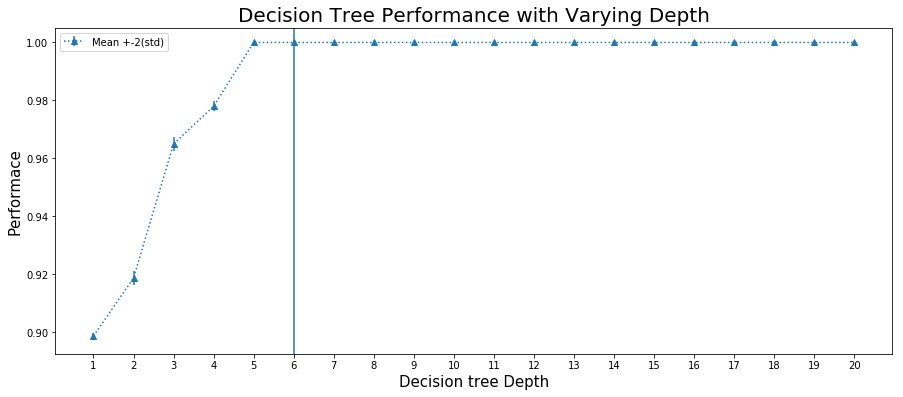

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
fig, ax = plt.subplots(1,1, figsize=(15,6))
x = list(range(1,21))
means = []
stds = []
for cur_depth in range(1,21):
    decision_tree_model = DecisionTreeClassifier(max_depth = cur_depth)
    scores = cross_val_score(decision_tree_model, X_train, y_train, cv=5)
    means.append(np.mean(scores))
    stds.append(2*np.std(scores))
    
ax.errorbar(x, means, stds, marker='^', linestyle='dotted', label="Mean +-2(std)")
#ax.plot(x,means,'o',color="g")
ax.set_xticks(x)
ax.axvline(x=6)
ax.set_xlabel("Decision tree Depth", fontsize=15)
ax.set_ylabel("Performace", fontsize=15)
ax.set_title("Decision Tree Performance with Varying Depth", fontsize=20)
ax.legend()


**Looking at the above graph looks like depth 6 seems to be perfect for our data. So we are going to use that depth to build our model and try testing it on the test data set ** 

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

decision_tree_model = DecisionTreeClassifier(max_depth = 6).fit(X_train, y_train)

model_collection["decision_tree"] = decision_tree_model

In [18]:
score = decision_tree_model.score(X_test, y_test)

print("Decision Tree Classifier Model score for test data: {0:4.4}%".format(score*100))


Decision Tree Classifier Model score for test data: 97.08%


Our decision tree seems to be peforming very poorly compared to other models, 
There are mulitple strategies that we have learnt in the class, we can apply 
Boosting , Bagging and Prunning to improve the results of the decision tree

We are going to try **Boosting(AdaBoost) and Bagging ** and let's see if that improves the performance

## Random Forests Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=25, max_depth=6)
rf_model = rf.fit(X_train, y_train)
score = rf_model.score(X_test, y_test)

model_collection["random_forest"] = random_forest_model

print("Random Forest model score is ", score)

Random Forest model score is  1.0


### Boosting(AdaBoost Classifier)

In [ ]:
print(X_train.shape)
print(y_train.shape)

In [ ]:
from sklearn import ensemble
from sklearn import tree

fig, ax = plt.subplots(3,1, figsize=(15,15))
estimators_num = 400
x_labels=range(1,estimators_num+1)
#x_labels= list(range(1,5))
ada_scores_test = []
ada_scores_train = []
for depth in range(1,4):
    adaboost = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=depth), 
                                           n_estimators=estimators_num, learning_rate=.05)
    adamodel = adaboost.fit(X_train, y_train)
    
    ax[depth-1].plot(list(x_labels),list(adamodel.staged_score(X_train,y_train)),color="r",
                     label="Trainng score with depth {}".format(depth))
    ax[depth-1].plot(list(x_labels),list(adamodel.staged_score(X_test,y_test)),color="g", 
                     label="Test score with depth {}".format(depth))
    ax[depth-1].legend()
    
fig.suptitle("Ada Boost Model Score vs # of iterations", fontsize=20)
    
    


### Before We jump on to Neural Networks, 
### I would like to build an emsemble model with all the models that we have build so far and let's see how that changes our prediction

In [24]:


from sklearn.utils import resample
emsemble_train = pd.DataFrame()
emsemble_test = pd.DataFrame()
for model_name, model in model_collection.items():
    if(model_name=="poly_logistic_cv"):
        y_predict = model.predict(X_train_poly)
    elif():
         y_predict = model.predict(X_trai)
    
    emsemble_train[model_name] = y_predict
    
    if(model_name=="poly_logistic_cv"):
        y_predict_test = model.predict(X_test_poly)
    elif():
         y_predict_test = model.predict(X_test)
    
    emsemble_test[model_name] = y_predict_test
    


In [25]:
emsemble_test.head()

,simple_logistic,simple_logistic_CV,poly_logistic_cv,decision_tree,random_forest
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,0.0,0.0,0.0


In [26]:
emsemble_train.head()

,simple_logistic,simple_logistic_CV,poly_logistic_cv,decision_tree,random_forest
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0


In [28]:
from sklearn.metrics import accuracy_score
meta_test_predictions = np.mean(emsemble_test,axis=1) >.5 #do we have more than 50% 1s?
accuracy_score(y_test, meta_test_predictions)
score =  accuracy_score(y_test, meta_test_predictions)
print("Decision Tree Classifier Model score for test data: {0:4.4}%".format(score*100))

Decision Tree Classifier Model score for test data: 98.45%


## Neural Networks 

In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential([
    Dense(1000, input_shape=(5,), activation='relu'),
    Dropout(0.5),
    Dense(500, activation='relu'),
    Dropout(.5),
    Dense(100, activation='relu'),
    Dropout(.5),
    Dense(50, activation='relu'),
    Dropout(.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam')



In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1000)              6000      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               50100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                5050      
__________

In [35]:
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split = .2)

Train on 193468 samples, validate on 48368 samples
Epoch 1/5
193468/193468 [==============================] - 171s 884us/step - loss: 0.0625 - val_loss: 0.0354
Epoch 2/5
193468/193468 [==============================] - 174s 898us/step - loss: 0.0600 - val_loss: 0.0399
Epoch 3/5
193468/193468 [==============================] - 165s 855us/step - loss: 0.0624 - val_loss: 0.0392
Epoch 4/5
193468/193468 [==============================] - 165s 853us/step - loss: 0.0571 - val_loss: 0.0376
Epoch 5/5
193468/193468 [==============================] - 157s 814us/step - loss: 0.0602 - val_loss: 0.0364


In [38]:
print(model.evaluate(X_test, y_test))

80612/80612 [==============================] - 10s 125us/step
0.03686924080342081


**I was expecting much better result, this is horrible, I am sure it will improve when run for more epochs **

In [47]:
### Summary Report

models = ["Simple Logistic Regression", "Logistic Regression with CV", "Polynomial Logistic Regression",
          "Decision Tree Classifier", "Random Forest", "Ensembling", "Neural Network"]
models_score = ["89.62", "89.62","89.62","97.08","100","98.45", 0]
Models_performance_summary = pd.DataFrame({"Models" :models, "Performance Score": models_score}, columns=["Models", "Performance Score"])

Models_performance_summary

,Models,Performance Score
0,Simple Logistic Regression,89.62
1,Logistic Regression with CV,89.62
2,Polynomial Logistic Regression,89.62
3,Decision Tree Classifier,97.08
4,Random Forest,100
5,Ensembling,98.45
6,Neural Network,0
